In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from tqdm import tqdm
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Demographics

In [2]:
## Load data.
demo = read_csv(os.path.join('data', 's1', 'demographics.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
demo = demo[demo.subject.isin(reject.query('reject == 0').subject)].reset_index(drop=True)

### 1.1 Gender

In [3]:
## Count responses.
gb = demo.groupby('gender').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('gender').sort_values('count', ascending=False))

                count     %
gender                     
Man                65  59.1
Woman              43  39.1
Other               1   0.9
Rather not say      1   0.9


### 1.2 Age

In [4]:
demo.age.describe().round(1)

count    110.0
mean      39.6
std       11.0
min       23.0
25%       31.0
50%       37.0
75%       46.0
max       69.0
Name: age, dtype: float64

#### Discretized

In [5]:
## Discretize ages.
demo['age_cat'] = np.digitize(demo.age, [29.5, 39.5, 49.5, 59.5])

## Count responses.
gb = demo.groupby('age_cat').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
gb.index = ['18-29', '30-39', '40-49', '50-59', '60 and older']
print(gb[['count','%']])

              count     %
18-29            21  19.1
30-39            42  38.2
40-49            26  23.6
50-59            14  12.7
60 and older      7   6.4


### 1.3 Race & ethnicity

#### Ethnicity

In [6]:
## Count responses.
gb = demo.groupby('ethnicity').subject.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('ethnicity').sort_values('count', ascending=False))

                        count     %
ethnicity                          
Not Hispanic or Latino    101  91.8
Hispanic or Latino          8   7.3
Rather not say              1   0.9


#### Race

In [7]:
## Unpack responses.
gb = DataFrame(dict(race = [r for resp in demo.race for r in eval(resp)]))

## Count responses.
gb = gb.groupby('race').race.count().reset_index(name='count')
gb['%'] = gb['count'].transform(lambda x: np.round(x / x.sum() * 100, 1))
print(gb.set_index('race').sort_values('count', ascending=False))

                               count     %
race                                      
White                             97  83.6
Black or African American         10   8.6
American Indian/Alaska Native      3   2.6
Asian                              3   2.6
Rather not say                     3   2.6


## Section 2: Behavior

In [8]:
## Define parameters.
sessions = ['s1', 's2', 's3']

## Iteratively load data.
data = concat([read_csv(os.path.join('data', session, 'pgng.csv'))
               for session in ['s1','s2','s3']])

## Restrict participants.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    110
2     97
3     99
Name: subject, dtype: int64


### 2.1 Learning curves

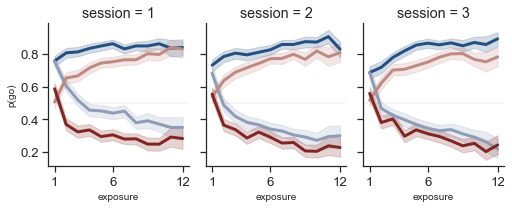

In [9]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3], aspect=0.8)

## Define aesthetics.
palette = ['#234f81', '#8e9cb8', '#bf8a82', '#812623']
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, 
      lw=3, errorbar=('ci', 95))

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=[1,6,12])
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

### 2.2 Descriptive statistics

In [10]:
from itertools import combinations

## Define parameters.
n_iter = 5000
sessions = [1,2,3]
pairs = list(combinations(sessions, 2))

## Define convenience functions.
def mad(x):
    """Median absolute difference."""
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

def cohens_d(x, popmean=0):
    """Cohen's D for one-sample median."""
    return np.abs(np.nanmedian(x) - popmean) / (mad(x) / 0.6745)

#### 2.2.1 Overall performance

**Within-session comparisons**

In [11]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', 'session')
pivot -= 0.5

## Compute observed effects.
obs = pivot.median().values

## Compute effect sizes.
d = pivot.apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute sign.
    pivot = pivot * np.random.choice([1,-1], pivot.shape, replace=True)
    
    ## Compute observed effects.
    null[n] = pivot.median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs + 0.5, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:05<00:00, 852.82it/s]


,obs,d,pval,fwer
session,,,,
1,0.675,1.828,0.0,0.0
2,0.717,2.063,0.0,0.0
3,0.696,1.441,0.0,0.0


**Between-session comparisons**

In [12]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', 'session')
pivot -= 0.5

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:16<00:00, 296.69it/s]


obs      d   pval   fwer
s1 s2                            
1  2  -0.021  0.337  0.004  0.008
   3  -0.012  0.156  0.127  0.326
2  3   0.008  0.135  0.329  0.685

#### 2.2.2 Main effect: required action

**Within-session comparisons**

In [13]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'action')

## Compute observed effects.
obs = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['go'] - pivot['no-go']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:35<00:00, 140.56it/s]


,obs,d,pval,fwer
session,,,,
1,0.192,1.108,0.0,0.0
2,0.133,0.899,0.0,0.0
3,0.142,0.882,0.0,0.0


**Between-session comparisons**

In [14]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['action','session'])
pivot = pivot['go'] - pivot['no-go']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:16<00:00, 297.88it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.050  0.405  0.002  0.005
   3   0.058  0.429  0.002  0.002
2  3   0.025  0.202  0.147  0.364

#### 2.2.3 Main effect: outcome valence

**Within-session comparisons**

In [15]:
np.random.seed(47404)

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', ['session','subject'], 'valence')

## Compute observed effects.
obs = (pivot['win'] - pivot['lose']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['win'] - pivot['lose']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['win'] - pivot['lose']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:37<00:00, 134.56it/s]


,obs,d,pval,fwer
session,,,,
1,-0.025,0.289,0.002,0.008
2,0.008,0.096,0.236,0.908
3,0.025,0.337,0.005,0.008


**Between-session comparisons**

In [16]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['valence','session'])
pivot = pivot['win'] - pivot['lose']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:17<00:00, 291.59it/s]


obs      d   pval   fwer
s1 s2                            
1  2  -0.033  0.300  0.035  0.094
   3  -0.050  0.450  0.000  0.001
2  3  -0.008  0.075  0.508  0.867

#### 2.2.4 Interaction effect: action type X outcome valence

**Within-session comparisons**

In [17]:
np.random.seed(47404)

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', ['session','subject'], 'congruence')

## Compute observed effects.
obs = (pivot['c'] - pivot['i']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['c'] - pivot['i']).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['c'] - pivot['i']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:35<00:00, 140.98it/s]


,obs,d,pval,fwer
session,,,,
1,0.125,1.065,0.0,0.000
2,0.083,0.843,0.0,0.000
3,0.075,0.867,0.0,0.001


**Between-session comparisons**

In [18]:
np.random.seed(47404)

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', 'subject', ['congruence','session'])
pivot = pivot['c'] - pivot['i']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((obs[:,np.newaxis] < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:20<00:00, 248.75it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.042  0.281  0.009  0.028
   3   0.042  0.337  0.011  0.028
2  3   0.000  0.000  0.847  0.999

#### 2.2.5 Secondary effect: feedback type 

**Within-session comparisons**

In [19]:
## Define previous exposure.
data['prev_sham'] = data.groupby(['subject','session','stimulus']).sham.transform(np.roll, 1)
data.loc[data.exposure == 1, 'prev_sham'] = np.nan

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'prev_sham')

## Compute observed effects.
obs = (pivot[0] - pivot[1]).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot[0] - pivot[1]).groupby(level=0).apply(cohens_d).values

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot[0] - pivot[1]).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index('session').round(3)

100%|██████████| 5000/5000 [00:35<00:00, 141.32it/s]


,obs,d,pval,fwer
session,,,,
1,0.282,2.254,0.0,0.0
2,0.294,2.142,0.0,0.0
3,0.268,2.267,0.0,0.0


**Between-session comparisons**

In [20]:
np.random.seed(47404)

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['prev_sham','session'])
pivot = pivot[0] - pivot[1]

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

## Report summary.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer))
summary.set_index(['s1','s2']).round(3)

100%|██████████| 5000/5000 [00:18<00:00, 267.85it/s]


obs      d   pval   fwer
s1 s2                            
1  2   0.017  0.139  0.295  0.643
   3   0.008  0.057  0.619  0.937
2  3   0.021  0.132  0.196  0.461

### 2.3 Individual-differences

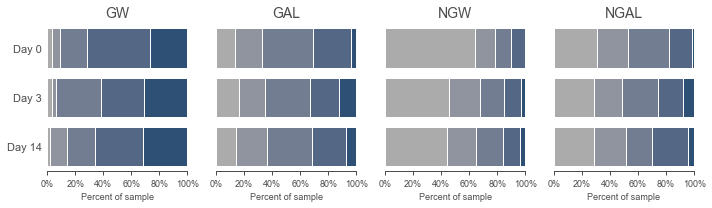

In [21]:
## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, np.arange(0.6,1.0,0.1))

## Calculate proportion of participants in each bin.
gb = gb.groupby(['robot','session','score']).subject.count().reset_index()
gb['prop'] = gb.groupby(['robot','session']).subject.transform(lambda x: x / x.sum())
gb['cumprop'] = gb.groupby(['robot','session']).prop.transform(np.cumsum)

## Initialize canvas.
fig, axes = plt.subplots(1, 4, figsize=(10,3))
palette = sns.color_palette('crest_r', n_colors=gb.score.nunique()).as_hex()
palette = ['#234f81', '#4c658c', '#6d7b96', '#8d93a1', '#ababab']

## Iteratively plot.
for i, (ax, robot) in enumerate(zip(axes, ['gw','gal','ngw','ngal'])):

    ## Stacked barchart. 
    for score, color in zip(np.unique(gb.score)[::-1], palette):    
    
        ## Plot scores.
        q = f'robot == "{robot}" and score == {score}'
        sns.barplot(x='cumprop', y='session', data=gb.query(q), order=[1,2,3], 
                    palette=np.repeat(color, 4), orient='h', ax=ax)
    
    ## Annotations.
    # for y, session in enumerate([1,2,3]):
    #     try: v = gb.set_index(['robot','session','score']).loc[(robot,session,4)].prop
    #     except KeyError: v = 1
    #     ax.annotate('%0.1f%%' %(v*1e2), (0,0), (1-v/2, y), ha='center', va='center',
    #                 color='w', fontsize=10)
    
    ## Adjust x-axis.
    ax.set(xlim=(0,1), xticks=np.linspace(0,1,6))
    ax.set_xticklabels(['%0.0f%%' %p for p in np.linspace(0,1e2,6)], fontsize=9, color='0.3')
    ax.set_xlabel('Percent of sample', fontsize=9, color='0.3')

    ## Adjust y-axis.
    ax.set(ylabel='', yticks=np.arange(3), yticklabels=[])
    if not i: ax.set_yticklabels(['Day 0', 'Day 3', 'Day 14'], ha='right',
                                 fontsize=11, color='0.3')
    
    ## Adjust title.
    ax.set_title(robot.upper(), fontsize=14, color='0.3')
    
    ## Modify ax spines.
    ax.yaxis.set_tick_params(pad=1)
    ax.spines['bottom'].set(linewidth=1, color='0.3')
    ax.tick_params(bottom=True, left=False, color='0.3', length=4, width=1)
    sns.despine(ax=ax, left=True, right=True, top=True, bottom=False)
    
plt.tight_layout()